<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/10_Time_series_bitcoin_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

### Get Data
Historical data of Bitcoin

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-08-02 06:44:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2021-08-02 06:44:04 (11.1 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [3]:
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv')

In [4]:
df.Date = pd.to_datetime(df.Date)
df = df.rename(columns = {'Date': 'date'}).set_index('date')

In [5]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [6]:
df_bc = df[['Closing Price (USD)']].rename(columns = {'Closing Price (USD)':'price'})

In [7]:
df_bc.head()

,price
date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


### Inspect our data

Text(0.5, 1.0, 'Price of bitcoin from 1 Oct 2013 to 18 May 2021')

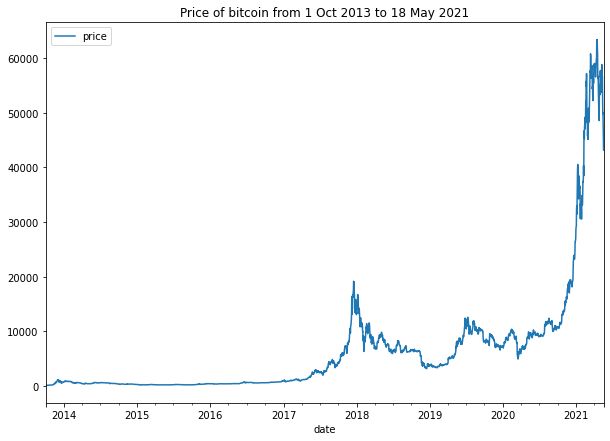

In [8]:
df_bc.plot(figsize = (10,7))
plt.title('Price of bitcoin from 1 Oct 2013 to 18 May 2021')

In [9]:
df_bc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


### Read Data with Python csv

In [10]:
timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 'r') as f:
  csv_reader = csv.reader(f, delimiter = ',')
  next(csv_reader) #skip first line (header)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], '%Y-%m-%d'))
    btc_price.append(float(line[2]))

In [11]:
timesteps[:2], btc_price[:2]

([datetime.datetime(2013, 10, 1, 0, 0), datetime.datetime(2013, 10, 2, 0, 0)],
 [123.65499, 125.455])

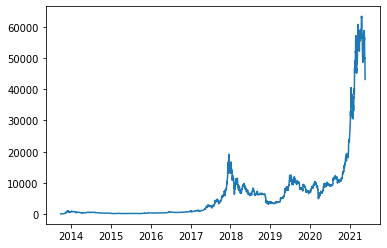

In [12]:
plt.plot(timesteps, btc_price)

### Create test train data sets

In [13]:
train_length = int(0.8*len(timesteps))
X_train, y_train = timesteps[:train_length], btc_price[:train_length]
X_test, y_test = timesteps[train_length:], btc_price[train_length:]

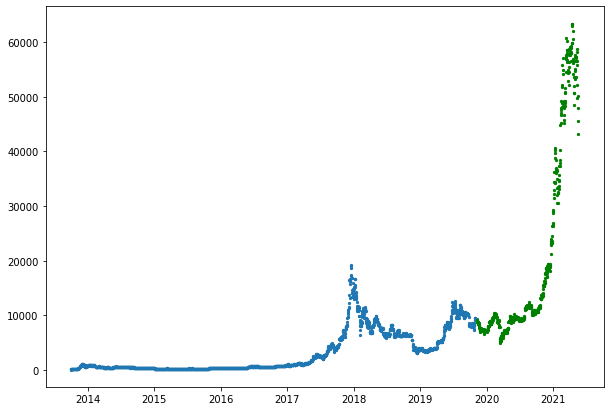

In [14]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s = 5, label = 'Train data')
plt.scatter(X_test, y_test, s = 5, label = 'Test data', c = 'green')
plt.show()

### Helper function to plot time series

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

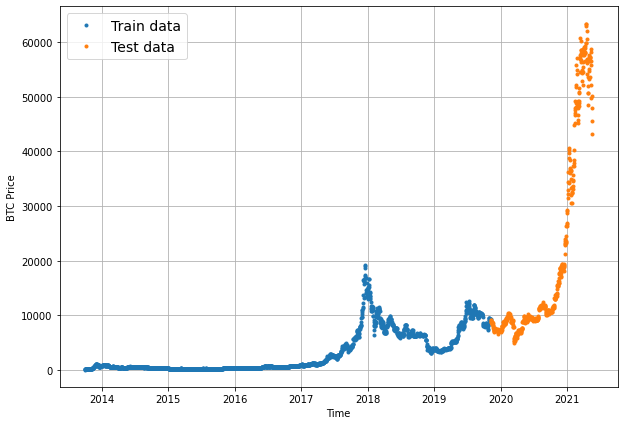

In [16]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

horizon = number of timesteps to predict into future

window = number of timesteps from past used to predict horizon

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

We are going to do those modelling experiments:

- 0 Naïve model (baseline)
- 1	Dense model	horizont 1 window 7
- 2	Same as 1	horizont 1 window	30
- 3	Same as 1	horizont 7 window	30
- 4	Conv1D	horizont 1	window 7
- 5	LSTM	horizont 1	window 7
- 6	Same as 1 (but with multivariate data)	horizont 1	window 7	Block reward size
- 7	N-BEATs Algorithm	horizont 1	window 7
- 8	Ensemble (multiple models optimized on different loss functions)	horizont 1	window 7
- 9	Future prediction model (model to predict future values) horizont	1 window	7
- 10	Same as 1 (but with turkey 🦃 data introduced)	horizont 1	window 7	


### 0 Model: Naive
$$\hat{y}_{t} = y_{t-1}$$

In [25]:
naive_forecast = y_test[:-1]

#### Plot Naive forecast

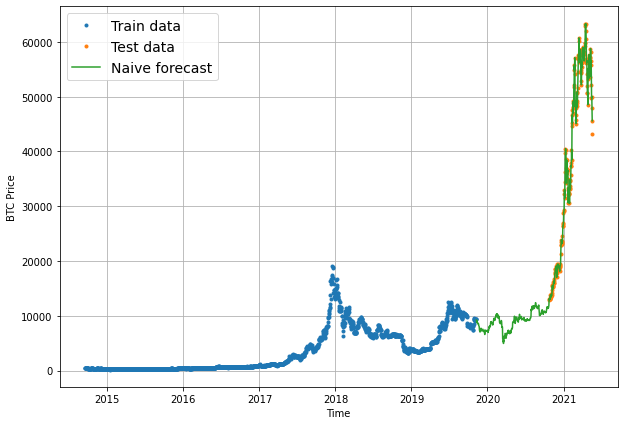

In [26]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, start = 350, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start = 350, label="Test data")
plot_time_series(timesteps=X_test[1:], values = naive_forecast, format = '-', label="Naive forecast")

###Evaluating forecast model
Scale-dependent errors: MAE tf.keras.metrics.mean_absolute_error(), RMSE tf.sqrt(tf.keras.metrics.mean_square_error())

Percentage errors: MAPE tf.keras.metrics.mean_absolute_percentage_error(), sMAPE custom implementation

Scaled errors: MASE See sktime's mase_loss() Less then 1 beats naive predition

In [27]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_no_season

In [28]:
mean_absolute_scaled_error(y_true = np.array(y_test[1:]), y_pred = np.array(naive_forecast)).numpy()

0.9995699939182626

#### Function to save all results

In [29]:
df_results = pd.DataFrame(columns = ['model', 'MAE', 'RMSE', 'MAPE', 'MASE'])

In [30]:
def save_results(model_name, y_pred, y_true = y_test[1:]):
  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  MAE = int(mean_absolute_error(y_true, y_pred).numpy())
  RMSE = int(tf.sqrt(tf.keras.metrics.mean_squared_error(y_true, y_pred)).numpy())
  MAPE = round(tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred).numpy(),2)
  MASE = mean_absolute_scaled_error(y_true, y_pred).numpy()
  df_results.loc[len(df_results)] = [model_name, MAE, RMSE, MAPE, MASE]

In [31]:
save_results('Base_naive', naive_forecast)

In [32]:
df_results

,model,MAE,RMSE,MAPE,MASE
0,Base_naive,567,1071,2.52,0.99957


### Other models to try
Moving average	https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

ARIMA (Autoregression Integrated Moving Average)	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

sktime (Scikit-Learn for time series)	https://github.com/alan-turing-institute/sktime

TensorFlow Decision Forests (random forest, gradient boosting trees)	https://www.tensorflow.org/decision_forests

Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)	https://github.com/facebookresearch/Kats

LinkedIn Greykite (flexible, intuitive and fast forecasts)	https://github.com/linkedin/greykite


### Format Data: Windowing our data
Windowing for one week:

[0,1,2,3,4,5,6] -> [7]

[1,2,3,4,5,6,7] -> [8]

[2,3,4,5,6,7,8] -> [9]

In [33]:
print(f'We want to use: {y_train[:7]} to predict {y_train[7]}')

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict 123.033


In [34]:
HORIZON = 1
WINDOW_SIZE = 7

In [35]:
#Create the function to label windowed data
def get_labeled_window(x, horizon = HORIZON):
  """Creates labels for windowed dataset.
  input = [0,1,2,3,4,5,6,7] output = [0,1,2,3,4,5,6], [7]
  """
  return x[:, :-horizon], x[:, -horizon:]

In [36]:
test_window, test_labels = get_labeled_window(tf.expand_dims(tf.range(8), axis = 0))

In [37]:
test_window, test_labels

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

In [43]:
train_data = np.array([], dtype = 'float32')
train_data

array([], dtype=float32)

In [59]:
def make_windows(y, window_size = WINDOW_SIZE, horizon = HORIZON):
  """Turns 1D array into sD array of sequental labeled widows"""
  y = np.array(y)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
  window_indexes = window_step + np.expand_dims(np.arange(len(y)-(window_size + horizon - 1)), axis=0).T
  # print(f'Window indexes: {window_indexes}\n Window shapes: {window_indexes.shape}')
  windowed_array = y[window_indexes]
  #get labeled windows
  windows, labels = get_labeled_window(windowed_array, horizon = horizon)
  return windows, labels

In [60]:
len(btc_price)

2787

In [61]:
windows, labels = make_windows(btc_price)

In [63]:
for i in range(3):
  print(f'Window: {windows[i]} -> Horizon (label): {labels[i]}')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Horizon (label): [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Horizon (label): [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Horizon (label): [125.96116]


#### Use tensorflow to create tf.ds
Another way to do this using tf function
 tf.keras.preprocessing.timeseries_dataset_from_array()

In [81]:
len(windows)

2780

In [70]:
np.array(btc_price[:10]).shape

(10,)

In [91]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(np.array(btc_price, dtype = 'float32'), 
                                                            targets = np.array(btc_price, dtype = 'float32')[7:], #need to shift right, otherwise give first element
                                                            sequence_length = 7, 
                                                            sequence_stride=1, 
                                                            sampling_rate=1,
                                                           batch_size = 1)

In [94]:
ds, len(ds)

(<BatchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>,
 2780)

In [93]:

for present_values, next_value in ds.take(3):
    print(f'Window: {tf.squeeze(present_values).numpy()} --> Label: {next_value.numpy()})


[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> [123.033]
[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> [124.049]
[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> [125.96116]
